In [1]:
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline

from mne.decoding import CSP
from mne.channels import read_layout
from loaddata import *
from sklearn import metrics as met
from mne.channels import make_standard_montage

print(__doc__)

Automatically created module for IPython interactive environment


In [2]:
"""
fp = {
      'aa' : {
          'cnt': './data/BCI_III_Dataset_4/aa/100Hz/data_set_IVa_aa_cnt.txt',
          'mrk': './data/BCI_III_Dataset_4/aa/100Hz/data_set_IVa_aa_mrk.txt',
          'lab': './data/BCI_III_Dataset_4/aa/TRUE_LABELS.txt',
          'chn': './data/BCI_III_Dataset_4/aa/100Hz/ch_names.txt',
          'pos':168,
          'freq': 100
          },    
       'al' : {
          'cnt': './data/BCI_III_Dataset_4/al/100Hz/data_set_IVa_al_cnt.txt',
          'mrk': './data/BCI_III_Dataset_4/al/100Hz/data_set_IVa_al_mrk.txt',
          'lab': './data/BCI_III_Dataset_4/al/TRUE_LABELS.txt',
          'chn': './data/BCI_III_Dataset_4/al/100Hz/ch_names.txt',
          'pos':224,
          'freq': 100
          },
       'av' : {
          'cnt': './data/BCI_III_Dataset_4/av/100Hz/data_set_IVa_av_cnt.txt',
          'mrk': './data/BCI_III_Dataset_4/av/100Hz/data_set_IVa_av_mrk.txt',
          'lab': './data/BCI_III_Dataset_4/av/TRUE_LABELS.txt',
          'chn': './data/BCI_III_Dataset_4/av/100Hz/ch_names.txt',
          'pos':84,
          'freq': 100
          },
       'aw' : {
          'cnt': './data/BCI_III_Dataset_4/aw/100Hz/data_set_IVa_aw_cnt.txt',
          'mrk': './data/BCI_III_Dataset_4/aw/100Hz/data_set_IVa_aw_mrk.txt',
          'lab': './data/BCI_III_Dataset_4/aw/TRUE_LABELS.txt',
          'chn': './data/BCI_III_Dataset_4/aw/100Hz/ch_names.txt',
          'pos':56,
          'freq': 100
          },
       'ay' : {
          'cnt': './data/BCI_III_Dataset_4/ay/100Hz/data_set_IVa_ay_cnt.txt',
          'mrk': './data/BCI_III_Dataset_4/ay/100Hz/data_set_IVa_ay_mrk.txt',
          'lab': './data/BCI_III_Dataset_4/ay/TRUE_LABELS.txt',
          'chn': './data/BCI_III_Dataset_4/ay/100Hz/ch_names.txt',
          'pos':28,
          'freq': 100
          }

}
"""
fp = {
       'al' : {
          'cnt': './data/BCI_III_Dataset_4/al/100Hz/data_set_IVa_al_cnt.txt',
          'mrk': './data/BCI_III_Dataset_4/al/100Hz/data_set_IVa_al_mrk.txt',
          'lab': './data/BCI_III_Dataset_4/al/TRUE_LABELS.txt',
          'chn': './data/BCI_III_Dataset_4/al/100Hz/ch_names.txt',
          'pos':224,
          'freq': 100
       }
}

#pick_chan = {
#    'al': ['C3', 'Cz', 'C5'],
#}

low_freq, high_freq = 7., 30.
tmin, tmax = 1., 2.

# event_id
event_id = {'right': 1, 'foot': 2}


In [3]:
def load(sujeto):
    #Se carga set de datos crudos
    raw = creatRawArray(sujeto)
    #Seleccionamos los canales a utilizar
    raw.pick_channels(['Fp1', 'Fp2', 'C3', 'C4','P7', 'P8', 'O1', 'O2'])
    
    #Seteamos la ubicacion de los canales segun el 
    montage = make_standard_montage('standard_1020')
    raw.set_montage(montage)
    
    #Se carga eventos
    events, labels = creatEventsArray(sujeto)

    # Se aplica filtros band-pass
    raw.filter(low_freq, high_freq, fir_design='firwin', skip_by_annotation='edge')

    #Se genera las epocas con los datos crudos y los eventos
    epochs = mne.Epochs(raw, events=events, event_id=event_id, tmin=tmin, tmax=tmax, baseline=None, preload=True,
                    verbose=False)

    #Se carga labels (convierte 1 -> -1 y 2 -> 0 )
    labels = epochs.events[:, -1] - 2

    #Lo convierte a matriz numpy
    epochs_data = epochs.get_data()

    #Se crea set de de pruebas y test
    train_x=epochs_data[:sujeto['pos']]
    train_y=labels[:sujeto['pos']]

    test_x =epochs_data[sujeto['pos']:]
    test_y=labels[sujeto['pos']:]
    
    return train_x, train_y, test_x, test_y, epochs


In [4]:
for key, sujeto in fp.items():
    train_x, train_y, test_x, test_y, epochs = load(sujeto)
    print(len(epochs.ch_names))
    
    #Assemble a classifier
    lda = LinearDiscriminantAnalysis()
    csp = CSP(n_components=8, reg=None, log=True, norm_trace=False)
    
    #Use scikit-learn Pipeline
    clf = Pipeline([('CSP', csp), ('LDA', lda)])
    
    clf.fit(train_x, train_y)
    result=clf.predict(test_x)
    
    print( met.confusion_matrix(test_y, result) )
    print( "Recall: ", met.recall_score(test_y, result, average=None) )
    print( "Precision: ", met.precision_score(test_y, result, average=None) )
    print( "F1: ", met.f1_score(test_y, result, average=None) )
    print( "Acurracy: ", met.accuracy_score(test_y, result) )
    
    tn, fp, fn, tp = met.confusion_matrix(test_y, result).ravel()
    print(tn, fp, fn, tp)
    
    print(met.classification_report(test_y, result))

Creating RawArray with float64 data, n_channels=118, n_times=283574
    Range : 0 ... 283573 =      0.000 ...  2835.730 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 165 samples (1.650 sec)

8
Computing rank from data with rank=None
    Using tolerance 3.8 (2.2e-16 eps * 8 dim * 2.2e+15  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from d

In [5]:
#event_id = {'right': 1, 'foot': 2}
print(epochs)
epoch_right = epochs['right']
epoch_foot =epochs['foot']

epoch_right.plot_image(picks=['Fp1', 'Fp2'])

<Epochs  |   280 events (all good), 1 - 2 sec, baseline off, ~1.8 MB, data loaded,
 'foot': 140
 'right': 140>
140 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
140 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


<Figure size 640x480 with 4 Axes>

<Figure size 640x480 with 4 Axes>

[<Figure size 640x480 with 4 Axes>, <Figure size 640x480 with 4 Axes>]

combining channels using "gfp"
combining channels using "gfp"


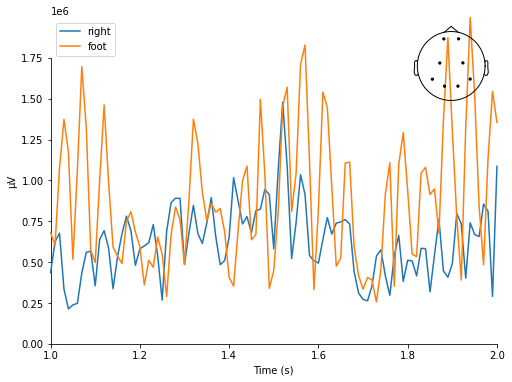

[<Figure size 576x432 with 2 Axes>]

In [6]:
right_evoked = epoch_right.average()
foot_evoked = epoch_foot.average()

mne.viz.plot_compare_evokeds(dict(right=right_evoked, foot=foot_evoked),
                             legend='upper left', show_sensors='upper right')


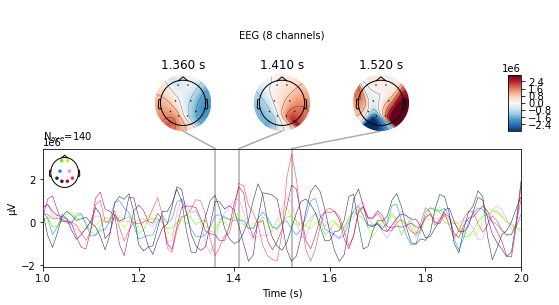

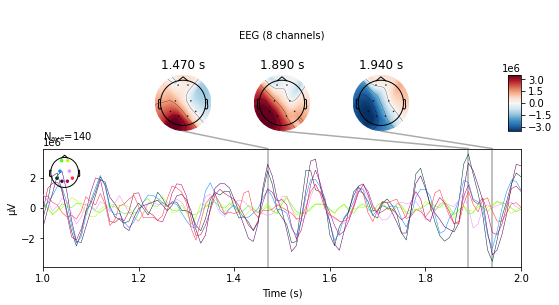

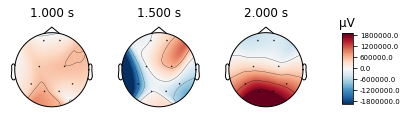

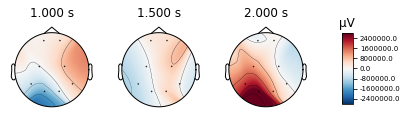

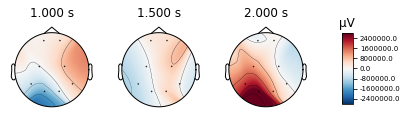

In [7]:
right_evoked.plot_joint()
foot_evoked.plot_joint()
right_evoked.plot_topomap(times=[1, 1.5, 2])
foot_evoked.plot_topomap(times=[1, 1.5, 2])